<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Intro-and-setup" data-toc-modified-id="Intro-and-setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Intro and setup</a></span></li><li><span><a href="#Implementing-a-Neural-Network" data-toc-modified-id="Implementing-a-Neural-Network-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Implementing a Neural Network</a></span></li><li><span><a href="#Training-the-network" data-toc-modified-id="Training-the-network-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Training the network</a></span><ul class="toc-item"><li><span><a href="#Training-with-ReLu-activation" data-toc-modified-id="Training-with-ReLu-activation-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Training with ReLu activation</a></span></li><li><span><a href="#Training-with-sigmoid-activation" data-toc-modified-id="Training-with-sigmoid-activation-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Training with sigmoid activation</a></span></li><li><span><a href="#Training-with-leaky-ReLu" data-toc-modified-id="Training-with-leaky-ReLu-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Training with leaky ReLu</a></span></li><li><span><a href="#Training-with-tanh" data-toc-modified-id="Training-with-tanh-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Training with <code>tanh</code></a></span></li></ul></li><li><span><a href="#Mini-batches" data-toc-modified-id="Mini-batches-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Mini batches</a></span></li><li><span><a href="#Evaluating-models" data-toc-modified-id="Evaluating-models-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Evaluating models</a></span></li><li><span><a href="#PyTorch-simple-implementation" data-toc-modified-id="PyTorch-simple-implementation-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>PyTorch simple implementation</a></span></li><li><span><a href="#Using-my-own-image" data-toc-modified-id="Using-my-own-image-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Using my own image</a></span></li></ul></div>

# Building a Neural Network from Scratch

## Intro and setup

The purpose of this notebook is simple. I want to build a simple Artificial Neural Network without using any framework such as `scikit-learn`, `PyTorch` or `TensorFlow`.
I believe this will help me gain a deeper understanding of the mathematics involved and will help that understanding sediment in my memory better.
First of all let's import some libraries. Since we aren't going to use any deep learning or machine learning frameworks, the number of imports will be limited.

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List
import pickle # To store data and trained models
from tqdm import tqdm # To visualize progress bars during training

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

We will be training and testing our network using the [MNIST_784 dataset](https://www.openml.org/d/554). We can download that as a `python` dictionary using `scikit-learn`.

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml(name="mnist_784")

In [3]:
with open("mnist.pickle", 'wb') as f:
    pickle.dump(mnist, f)

In [199]:
with open("mnist.pickle", 'rb') as f:
    mnist = pickle.load(f)

In [207]:
data = mnist.data
labels = mnist.target

In [65]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [66]:
# Let's select a random datapoint.
# np.random.seed(42)
n = np.random.choice(np.arange(data.shape[0]+1))
print(n)
test_img = data.iloc[n].values
test_label = mnist.target.iloc[n]

43545


In [67]:
print(test_img.shape)

(784,)


Image label: 6


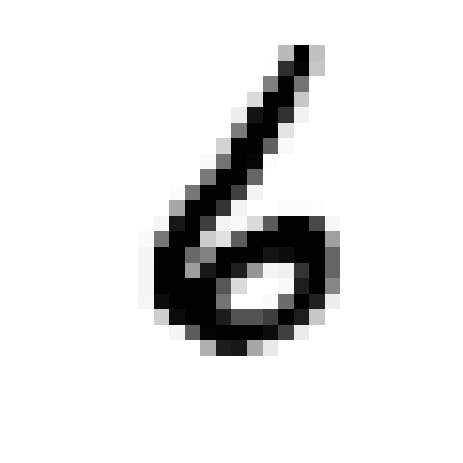

In [68]:
side_length = int(np.sqrt(test_img.shape))
reshaped_test_img = test_img.reshape(side_length, side_length)
print("Image label: " + str(test_label))
plt.imshow(reshaped_test_img, cmap="Greys")
plt.axis('off')
plt.show()

So we know that image is a vector of shape 784, which is a flattened 28 x 28 2D matrix.
If we split our dataset into a training set with e.g. 60.000 datapoints and a test set with 10.000 datapoints we will end up with the following: $input\;layer\;size = m*n$, where $m$ is the number of samples and $n$ the number of features. Hence in our case the network's input layer with have size (60.000 x 784).<br>Let's start by coding a simple NN with just one hidden layer.
If the hidden layer has say 4 nodes: how do we control the mapping from the input layer to the hidden layer? In other words, what should be the size of the **weight matrix**?

Each node in the input layer will connect to each input in the hidden layer. So we will need 784 * 4 = 3136 weights. And each node in the hidden layer will add a bias to each weighted sum so we'll need 4 biases.

As a rule: if layer $L_n$ has $s_n$ nodes and layer $L_{n+1}$ has $s_{n+1
}$ nodes then the $\Theta_n$ matrix mapping fron $L_n$ to $L_{n+1}$ will be of size $(s_{n+1},\;s_{n})$.

In [69]:
w1 = np.ones((4, 784)) * 0.01
z1 = np.dot(w1, data.T)
print(z1.shape)

(4, 70000)


In [70]:
w2 = np.ones((10, 4))
z2 = np.dot(w2, z1)
print(z2.shape)

(10, 70000)


(But remember: we need to add *biases* to each node in the hidden layer.)

## Implementing a Neural Network

Let's start by defining some **activation functions**:

In [71]:
def sigmoid(z: np.ndarray) -> np.ndarray:
    return 1.0 / (1.0 + np.exp(-z))

In [72]:
def relu(z: np.ndarray) -> np.ndarray:
    return np.maximum(0, z)

In [73]:
def tanh(z: np.ndarray) -> np.ndarray:
    return np.tanh(z)

In [74]:
def leaky_relu(z: np.ndarray) -> np.ndarray:
    return np.where(z > 0, z, z * 0.01)

For the final layer we will use **softmax** given that this is a multiclass classification problem.

In [75]:
def softmax(z: np.ndarray) -> np.ndarray:
    e = np.exp(z - np.max(z))
    return e / np.sum(e, axis=0, keepdims=True)

We are also going to need some pre-processing functions:

In [76]:
def normalize(x: np.ndarray) -> np.ndarray:
    return (x - np.min(x)) / (np.max(x) - np.min(x))

In [77]:
def one_hot_encode(x: np.ndarray, num_labels: int) -> np.ndarray:
    return np.eye(num_labels)[x]

Finally, we will need derivatives for the activation functions to perform gradient descent.

In [78]:
def derivative(function_name: str, z: np.ndarray) -> np.ndarray:
    if function_name == "sigmoid":
        return sigmoid(z) * (1 - sigmoid(z))
    if function_name == "tanh":
        return 1 - np.square(tanh(z))
    if function_name == "relu":
        y = (z > 0) * 1
        return y
    if function_name == "leaky_relu":
        return  np.where(z > 0, 1, 0.01)
    return "No such activation"

We now have everything we need for our deep neural network.

In [127]:
class NN(object):
    def __init__(self, X: np.ndarray, y: np.ndarray, X_test: np.ndarray, y_test: np.ndarray, activation: str, num_labels: int, architecture: List[int]):
        self.X = normalize(X) # normalize training data in range 0,1
        assert np.all((self.X >= 0) | (self.X <= 1)) # test that normalize succeded
        self.X, self.X_test = X.copy(), X_test.copy()
        self.y, self.y_test = y.copy(), y_test.copy()
        self.layers = {} # define dict to store results of activation
        self.architecture = architecture # size of hidden layers as array  
        self.activation = activation # activation function
        assert self.activation in ["relu", "tanh", "sigmoid", "leaky_relu"]
        self.parameters = {}
        self.num_labels = num_labels
        self.m = X.shape[1]
        self.architecture.append(self.num_labels)
        self.num_input_features = X.shape[0]
        self.architecture.insert(0, self.num_input_features)
        self.L = len(architecture) 
        assert self.X.shape == (self.num_input_features, self.m)
        assert self.y.shape == (self.num_labels, self.m)
        
    def initialize_parameters(self):
        for i in range(1, self.L):
            print(f"Initializing parameters for layer: {i}.")
            self.parameters["w"+str(i)] = np.random.randn(self.architecture[i], self.architecture[i-1]) * 0.01
            self.parameters["b"+str(i)] = np.zeros((self.architecture[i], 1))
    
    
    def forward(self):
        params=self.parameters
        self.layers["a0"] = self.X
        for l in range(1, self.L-1):
            self.layers["z" + str(l)] = np.dot(params["w" + str(l)], 
                                               self.layers["a"+str(l-1)]) + params["b"+str(l)]
            self.layers["a" + str(l)] = eval(self.activation)(self.layers["z"+str(l)])
            assert self.layers["a"+str(l)].shape == (self.architecture[l], self.m)
        self.layers["z" + str(self.L-1)] = np.dot(params["w" + str(self.L-1)],
                                                  self.layers["a"+str(self.L-2)]) + params["b"+str(self.L-1)]
        self.layers["a"+str(self.L-1)] = softmax(self.layers["z"+str(self.L-1)])
        self.output = self.layers["a"+str(self.L-1)]
        assert self.output.shape == (self.num_labels, self.m)
        assert all([s for s in np.sum(self.output, axis=1)])        
        
        cost = - np.sum(self.y * np.log(self.output + 0.000000001))

        return cost, self.layers


    def backpropagate(self):
        derivatives = {}
        dZ = self.output - self.y
        assert dZ.shape == (self.num_labels, self.m)
        dW = np.dot(dZ, self.layers["a" + str(self.L-2)].T) / self.m
        db = np.sum(dZ, axis=1, keepdims=True) / self.m
        dAPrev = np.dot(self.parameters["w" + str(self.L-1)].T, dZ)
        derivatives["dW" + str(self.L-1)] = dW
        derivatives["db" + str(self.L-1)] = db
        
        for l in range(self.L-2, 0, -1):
            
            dZ = dAPrev * derivative(self.activation, self.layers["z" + str(l)])  
            dW = 1. / self.m * np.dot(dZ, self.layers["a" + str(l-1)].T)
            db = 1. / self.m * np.sum(dZ, axis=1, keepdims=True)
            if l > 1:
                dAPrev = np.dot(self.parameters["w" + str(l)].T, (dZ))
            derivatives["dW" + str(l)] = dW
            derivatives["db" + str(l)] = db
        self.derivatives = derivatives
        
        return self.derivatives

    
    def fit(self, lr=0.01, epochs=1000):
        self.costs = [] 
        self.initialize_parameters()
        self.accuracies = {"train": [], "test": []}
        for epoch in tqdm(range(epochs), colour="BLUE"):
            cost, cache = self.forward()
            self.costs.append(cost)
            derivatives = self.backpropagate()            
            for layer in range(1, self.L):
                self.parameters["w"+str(layer)] = self.parameters["w"+str(layer)] - lr * derivatives["dW" + str(layer)]
                self.parameters["b"+str(layer)] = self.parameters["b"+str(layer)] - lr * derivatives["db" + str(layer)]            
            train_accuracy = self.accuracy(self.X, self.y)
            test_accuracy = self.accuracy(self.X_test, self.y_test)
            if epoch % 10 == 0:
                print(f"Epoch: {epoch:3d} | Cost: {cost:.3f} | Accuracy: {train_accuracy:.3f}")
            self.accuracies["train"].append(train_accuracy)
            self.accuracies["test"].append(test_accuracy)
        print("Training terminated")


    def predict(self, x):
        params = self.parameters
        n_layers = self.L - 1
        values = [x]
        for l in range(1, n_layers):
            z = np.dot(params["w" + str(l)], values[l-1]) + params["b" + str(l)]
            a = eval(self.activation)(z)
            values.append(a)
        z = np.dot(params["w"+str(n_layers)], values[n_layers-1]) + params["b"+str(n_layers)]
        a = softmax(z)
        if x.shape[1]>1:
            ans = np.argmax(a, axis=0)
        else:
            ans = np.argmax(a)
        return ans
    
    
    def accuracy(self, X, y):
        P = self.predict(X)
        return sum(np.equal(P, np.argmax(y, axis=0))) / y.shape[1]*100
    
    
    def pickle_model(self, name: str):
        with open("fitted_model_"+ name + ".pickle", "wb") as modelFile:
            pickle.dump(self, modelFile)
    
    
    def plot_counts(self):
        counts = np.unique(np.argmax(self.output, axis=0), return_counts=True)
        plt.bar(counts[0], counts[1], color="navy")
        plt.ylabel("Counts")
        plt.xlabel("y_hat")
        plt.title("Distribution of predictions")
        plt.show()
    
    
    def plot_cost(self, lr):
        plt.figure(figsize=(8, 4))
        plt.plot(np.arange(0, len(self.costs)), self.costs, lw=1, color="orange")
        plt.title(f"Learning rate: {lr}\nFinal Cost: {self.costs[-1]:.5f}", fontdict={
        "family":"sans-serif", 
        "size": "12"})
        plt.xlabel("Epoch")
        plt.ylabel("Cost")
        plt.show()
    
    
    def plot_accuracies(self, lr):
        acc = self.accuracies
        fig = plt.figure(figsize=(6,4))
        ax = fig.add_subplot(111)
        ax.plot(acc["train"], label="train")
        ax.plot(acc["test"], label="test")
        plt.legend(loc="lower right")
        ax.set_title("Accuracy")
        ax.annotate(f"Train: {acc['train'][-1]:.2f}", (len(acc["train"])+4, acc["train"][-1]+2), color="blue")
        ax.annotate(f"Test: {acc['test'][-1]:.2f}", (len(acc["test"])+4, acc["test"][-1]-2), color="orange")
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        plt.show()
    
    def __str__(self):                
        return str(self.architecture)

## Training the network

Let's split the data into a training and a test set.

In [235]:
# reloading data
with open("mnist.pickle", 'rb') as f:
    mnist = pickle.load(f)
data = mnist.data
labels = mnist.target

In [236]:
train_test_split_no = 60000

In [237]:
X_train = data.values[:train_test_split_no].T
y_train = labels[:train_test_split_no].values.astype(int)
y_train = one_hot_encode(y_train, 10).T

In [238]:
X_test = data.values[train_test_split_no:].T
y_test = labels[train_test_split_no:].values.astype(int)
y_test = one_hot_encode(y_test, 10).T

In [239]:
X_train.shape, X_test.shape

((784, 60000), (784, 10000))

### Training with ReLu activation

In [229]:
PARAMS = [X_train, y_train, X_test, y_test, "relu", 10, [512, 300]]

In [230]:
nn_relu = NN(*PARAMS)

In [231]:
epochs_relu = 50
lr_relu = 0.003

In [232]:
nn_relu.fit(lr=lr_relu, epochs=epochs_relu)

  0%|          | 0/50 [00:00<?, ?it/s]

Initializing parameters for layer: 1.
Initializing parameters for layer: 2.
Initializing parameters for layer: 3.


  2%|▏         | 1/50 [00:04<03:52,  4.74s/it]

Epoch:   0 | Cost: 146154.837 | Accuracy: 18.590


 22%|██▏       | 11/50 [00:54<03:17,  5.08s/it]

Epoch:  10 | Cost: 77131.526 | Accuracy: 75.060


 42%|████▏     | 21/50 [01:46<02:32,  5.24s/it]

Epoch:  20 | Cost: 47151.615 | Accuracy: 82.263


 62%|██████▏   | 31/50 [02:38<01:38,  5.17s/it]

Epoch:  30 | Cost: 35998.465 | Accuracy: 85.198


 82%|████████▏ | 41/50 [14:11<03:04, 20.55s/it] 

Epoch:  40 | Cost: 30510.154 | Accuracy: 86.967


100%|██████████| 50/50 [14:53<00:00, 17.87s/it]

Training terminated


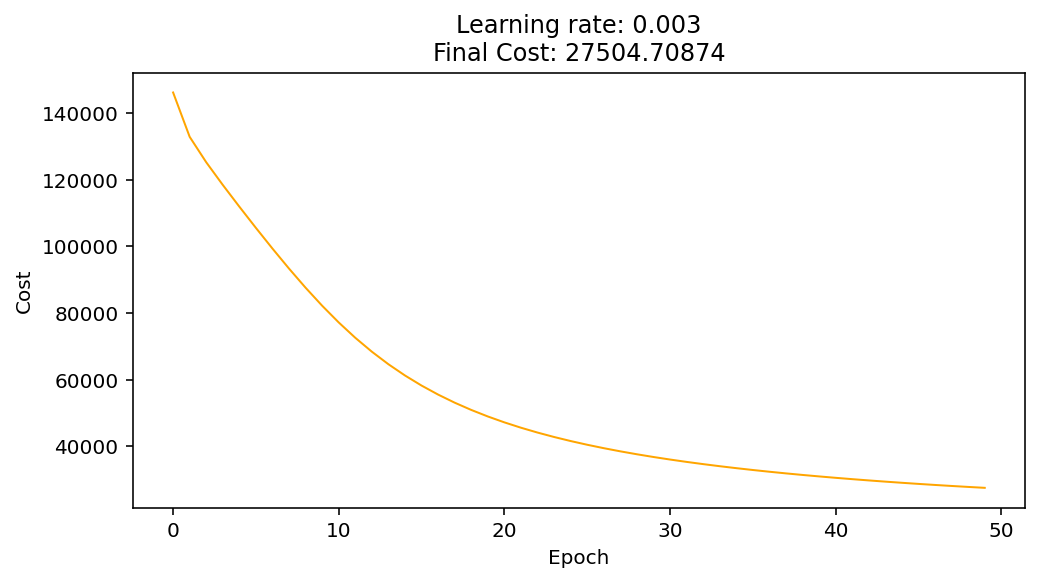

In [233]:
nn_relu.plot_cost(lr_relu)

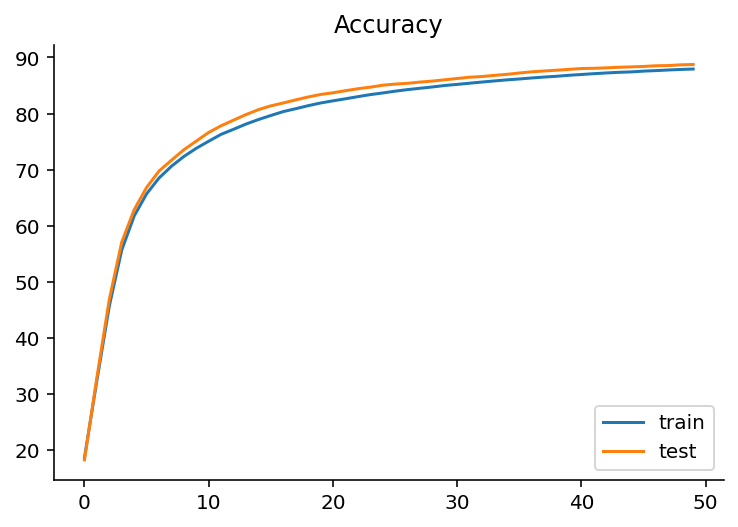

In [234]:
nn_relu.plot_accuracies(lr_relu)

In [219]:
nn_relu.pickle_model("relu")

In [131]:
with open("fitted_model_relu.pickle", "rb") as f:
    nn_relu = pickle.load(f)

### Training with sigmoid activation

In [240]:
PARAMS_sigmoid = [X_train, y_train, X_test, y_test, "sigmoid", 10, [512, 300]]

In [241]:
lr_sigmoid = 0.01
epochs_sigmoid = 150

In [242]:
nn_sigmoid = NN(*PARAMS_sigmoid)

In [ ]:
nn_sigmoid.fit(lr=lr_sigmoid, epochs=epochs_sigmoid)

  0%|          | 0/150 [00:00<?, ?it/s]

Initializing parameters for layer: 1.
Initializing parameters for layer: 2.
Initializing parameters for layer: 3.


  1%|          | 1/150 [00:06<16:18,  6.57s/it]

Epoch:   0 | Cost: 138685.114 | Accuracy: 9.737


  7%|▋         | 11/150 [01:09<14:37,  6.32s/it]

Epoch:  10 | Cost: 138125.949 | Accuracy: 9.737


 14%|█▍        | 21/150 [02:14<13:58,  6.50s/it]

Epoch:  20 | Cost: 137980.568 | Accuracy: 11.237


 21%|██        | 31/150 [03:19<13:07,  6.62s/it]

Epoch:  30 | Cost: 137912.456 | Accuracy: 11.237


 27%|██▋       | 40/150 [04:20<12:22,  6.75s/it]

In [366]:
nn_sigmoid.pickle_model("sigmoid")

In [37]:
with open("fitted_model_sigmoid.pickle", "rb") as f:
    nn_sigmoid = pickle.load(f)

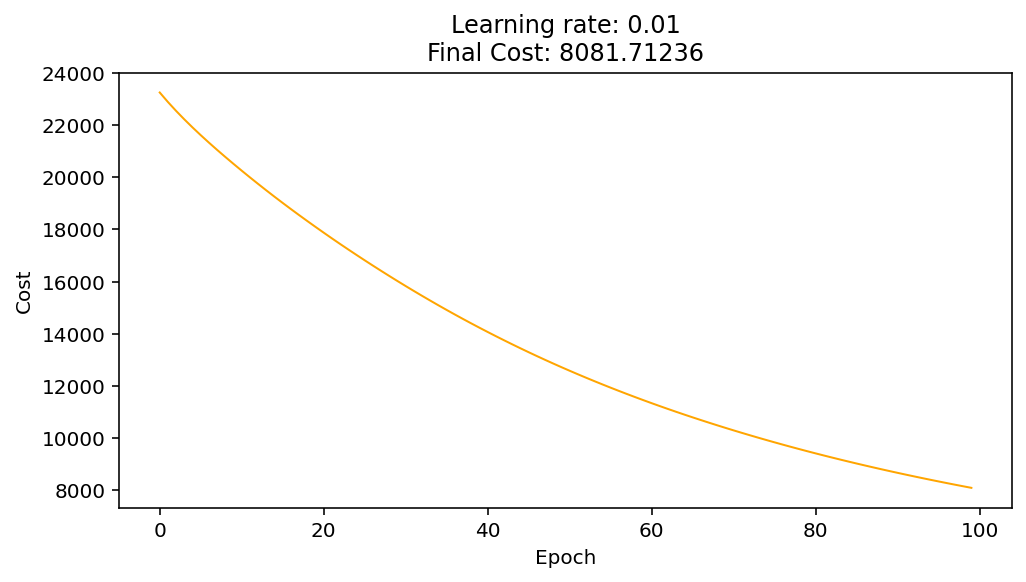

In [38]:
nn_sigmoid.plot_cost(lr_sigmoid)

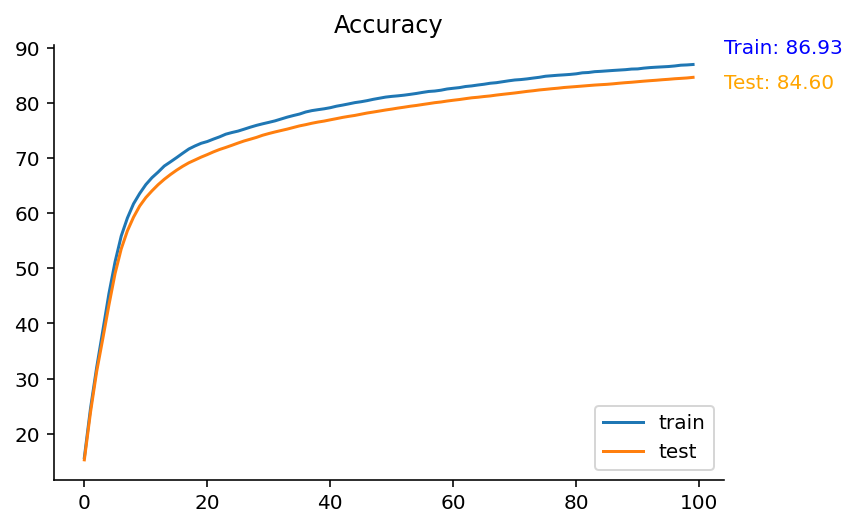

In [39]:
nn_sigmoid.plot_accuracies(lr_sigmoid)

### Training with leaky ReLu

In [77]:
PARAMS_leaky = [X_train, y_train, X_test, y_test, "leaky_relu", 10, [128, 32]]

In [78]:
nn_leaky = NN(*PARAMS_leaky)

In [79]:
lr_leaky = 0.003
epochs_leaky = 200

In [80]:
nn_leaky.fit(X_train, y_train, lr=lr_leaky, epochs=epochs_leaky)


  0%|          | 0/200 [00:00<?, ?it/s]

Initializing parameters for layer: 1.
Initializing parameters for layer: 2.
Initializing parameters for layer: 3.



  0%|          | 1/200 [00:01<04:26,  1.34s/it]

Epoch:   0 | Cost: 138393.976 | Accuracy: 8.328


  6%|▌         | 11/200 [00:13<03:56,  1.25s/it]

Epoch:  10 | Cost: 135399.276 | Accuracy: 22.795


 10%|█         | 21/200 [00:26<03:46,  1.26s/it]

Epoch:  20 | Cost: 130679.610 | Accuracy: 37.838


 16%|█▌        | 31/200 [00:38<03:31,  1.25s/it]

Epoch:  30 | Cost: 121661.152 | Accuracy: 48.312


 20%|██        | 41/200 [00:51<03:19,  1.25s/it]

Epoch:  40 | Cost: 105656.536 | Accuracy: 57.497


 26%|██▌       | 51/200 [01:04<03:07,  1.26s/it]

Epoch:  50 | Cost: 86155.206 | Accuracy: 65.415


 30%|███       | 61/200 [01:16<02:55,  1.26s/it]

Epoch:  60 | Cost: 69437.813 | Accuracy: 71.528


 36%|███▌      | 71/200 [01:29<02:42,  1.26s/it]

Epoch:  70 | Cost: 57214.183 | Accuracy: 75.895


 40%|████      | 81/200 [01:41<02:29,  1.26s/it]

Epoch:  80 | Cost: 48812.132 | Accuracy: 78.590


 46%|████▌     | 91/200 [01:54<02:20,  1.29s/it]

Epoch:  90 | Cost: 43022.844 | Accuracy: 80.557


 50%|█████     | 101/200 [02:12<02:51,  1.73s/it]

Epoch: 100 | Cost: 38870.653 | Accuracy: 82.018


 56%|█████▌    | 111/200 [02:25<01:54,  1.28s/it]

Epoch: 110 | Cost: 35757.852 | Accuracy: 83.222


 60%|██████    | 121/200 [02:38<01:38,  1.25s/it]

Epoch: 120 | Cost: 33334.466 | Accuracy: 84.337


 66%|██████▌   | 131/200 [02:50<01:26,  1.25s/it]

Epoch: 130 | Cost: 31388.424 | Accuracy: 85.223


 70%|███████   | 141/200 [03:03<01:14,  1.26s/it]

Epoch: 140 | Cost: 29786.601 | Accuracy: 85.925


 76%|███████▌  | 151/200 [03:16<01:01,  1.26s/it]

Epoch: 150 | Cost: 28443.348 | Accuracy: 86.587


 80%|████████  | 161/200 [03:28<00:48,  1.25s/it]

Epoch: 160 | Cost: 27301.659 | Accuracy: 87.080


 86%|████████▌ | 171/200 [03:41<00:36,  1.26s/it]

Epoch: 170 | Cost: 26328.781 | Accuracy: 87.465


 90%|█████████ | 181/200 [03:53<00:23,  1.25s/it]

Epoch: 180 | Cost: 25653.037 | Accuracy: 87.608


 96%|█████████▌| 191/200 [04:07<00:11,  1.31s/it]

Epoch: 190 | Cost: 27710.532 | Accuracy: 84.880


100%|██████████| 200/200 [04:18<00:00,  1.29s/it]

Training terminated


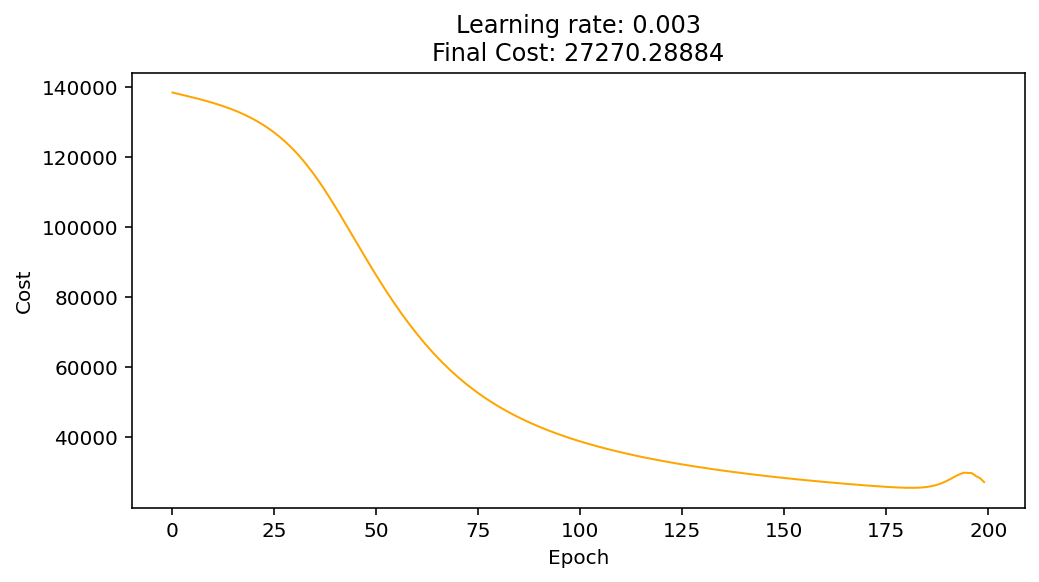

In [81]:
nn_leaky.plot_cost(lr=lr_leaky)

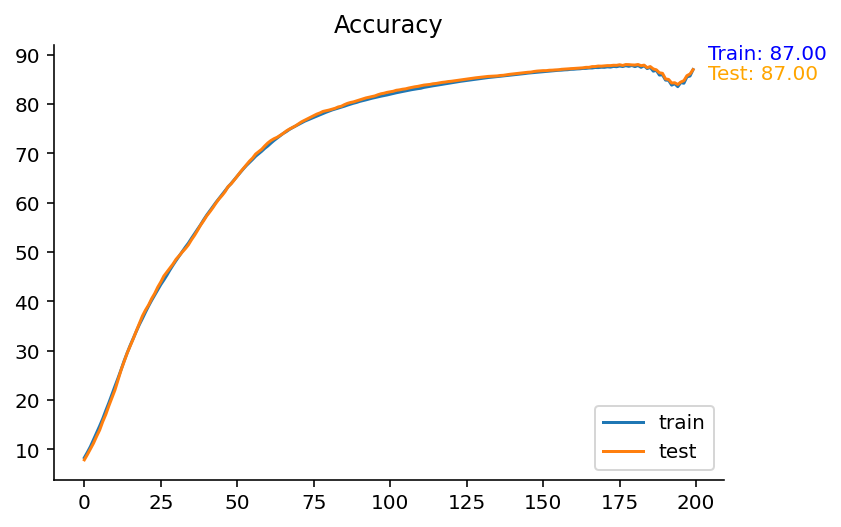

In [82]:
nn_leaky.plot_accuracies(lr_leaky)

In [320]:
nn_leaky.pickle_model("leaky")

In [321]:
with open("fitted_model_leaky.pickle", "rb") as f:
    nn_leaky = pickle.load(f)

### Training with `tanh`

In [322]:
PARAMS_tanh = [X_train, y_train, X_test, y_test, "relu", 10, [64, 10]]

In [323]:
nn_tanh = NN(*PARAMS_tanh)

In [324]:
nn_tanh.fit(X_train, y_train, lr=0.003, epochs=100)


  0%|          | 0/100 [00:00<?, ?it/s]

Initializing parameters for layer: 1.
Initializing parameters for layer: 2.
Initializing parameters for layer: 3.



  1%|          | 1/100 [00:00<00:56,  1.75it/s]

Epoch:   0 | Cost: 23043.854 | Accuracy: 11.450


 21%|██        | 21/100 [00:11<00:45,  1.75it/s]

Epoch:  20 | Cost: 22831.969 | Accuracy: 17.270


 41%|████      | 41/100 [00:21<00:32,  1.80it/s]

Epoch:  40 | Cost: 22245.258 | Accuracy: 15.060


 61%|██████    | 61/100 [00:33<00:21,  1.81it/s]

Epoch:  60 | Cost: 20813.700 | Accuracy: 23.370


 81%|████████  | 81/100 [00:43<00:10,  1.82it/s]

Epoch:  80 | Cost: 17567.665 | Accuracy: 42.770


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]

Training terminated


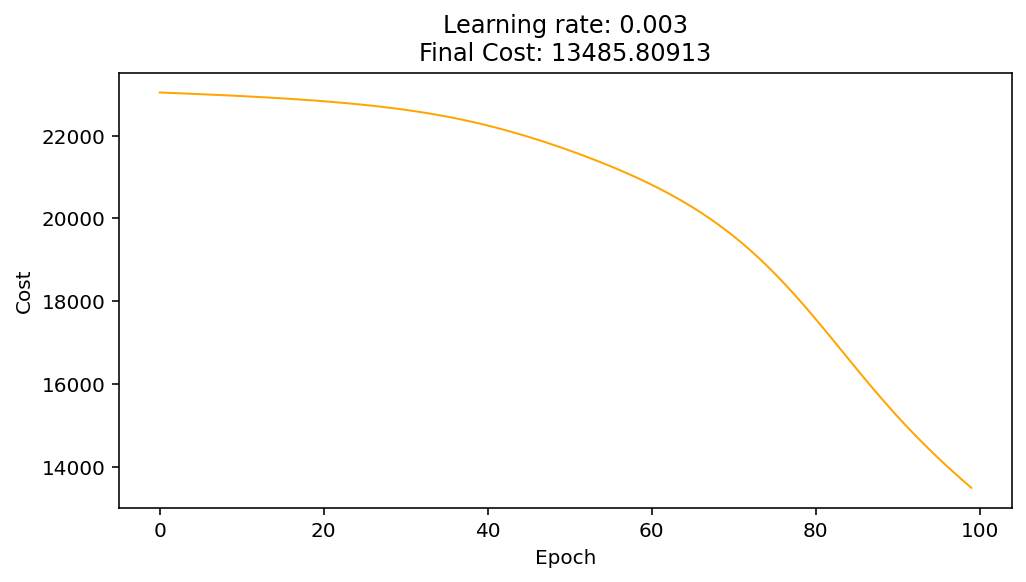

In [370]:
nn_tanh.plot_cost(lr=0.003)

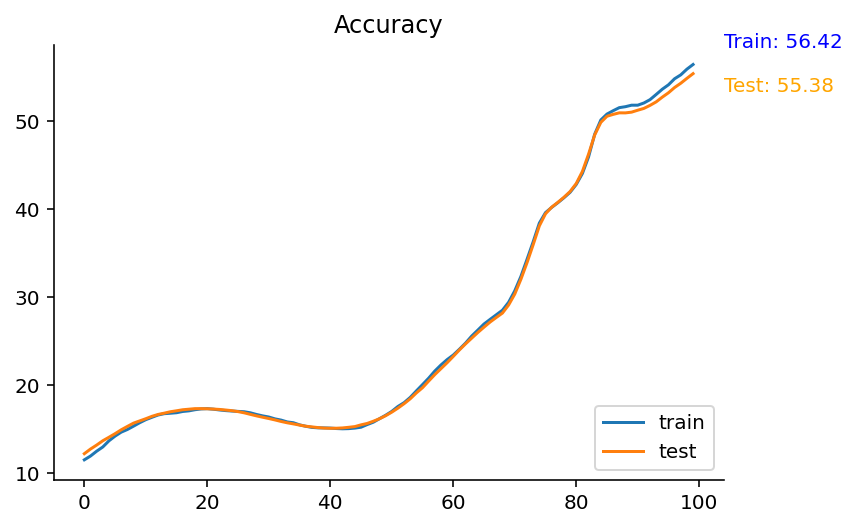

In [371]:
nn_tanh.plot_accuracies(lr=0.003)

In [372]:
nn_tanh.pickle_model("tanh")

In [373]:
with open("fitted_model_tanh.pickle", "rb") as f:
    nn_tanh = pickle.load(f)

## Mini batches

In [333]:
# Not yet implemented

def iterate_mini_batches(X, y, batch_size, shuffle=False):    
    no_of_samples = X.shape[1]
    if shuffle:
        ind_list = np.array([i for i in range(no_of_samples)])
        np.random.shuffle(ind_list)
        X  = X[:, ind_list]
        y = y[:, ind_list]
    for start_idx in range(0, no_of_samples, batch_size):
        if start_idx + batch_size <= no_of_samples:
            end_idx = start_idx+batch_size -1
        else:
            end_idx = (no_of_samples) % batch_size + start_idx + 1
        print(start_idx, end_idx)
        yield X[:, start_idx:end_idx], y[:, start_idx:end_idx]

## Evaluating models

In [33]:
from tabulate import tabulate
def print_accuracies(models, X_train, y_train, X_test, y_test):
    data = [[model.activation, model.architecture[1:-1], model.accuracy(X_train, y_train), model.accuracy(X_test, y_test)] for model in models]
    print(tabulate(data, headers=["Activation", "Architecture","Train", "Test"]))

In [34]:
print_accuracies([nn_relu, nn_sigmoid, nn_leaky], X_train, y_train, X_test, y_test)

NameError: name 'nn_sigmoid' is not defined

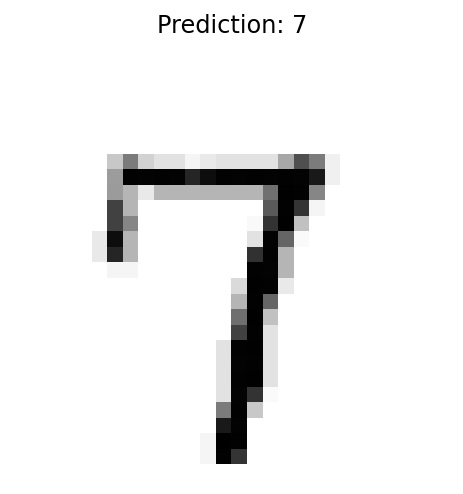

In [137]:
# Results for nn_relu
example_index = 2132
plt.imshow(X_test[:, example_index].reshape(28,28), cmap="Greys")
prediction = nn_relu.predict(X_test[:, example_index].reshape((X_test.shape[0], 1)))
plt.title("Prediction: " + str(prediction))
plt.axis('off')
plt.show()

In [138]:
X_test[:, example_index].shape

(784,)

In [139]:
def plot_predictions(model, X_test, labels, rows, cols):
    indexes = np.random.choice(range(X_test.shape[1]), rows * cols)
    fig, ax = plt.subplots(rows, cols, figsize=(5, 4))
    n = 0
    for i in range(rows):
        for j in range(cols):
            ix = indexes[n]
            example = X_test[:, ix].reshape(28,28)
            prediction = model.predict(X_test[:, ix].reshape((X_test[:, ix].shape[0], 1)))        
            subplot = ax[i, j]
            subplot.set_title(f"Prediction: {prediction}\nLabel: {np.argmax(labels[:, ix])}")
            subplot.imshow(example, cmap="Greys")
            subplot.axis('off')
            n += 1
    plt.tight_layout()
    plt.show()

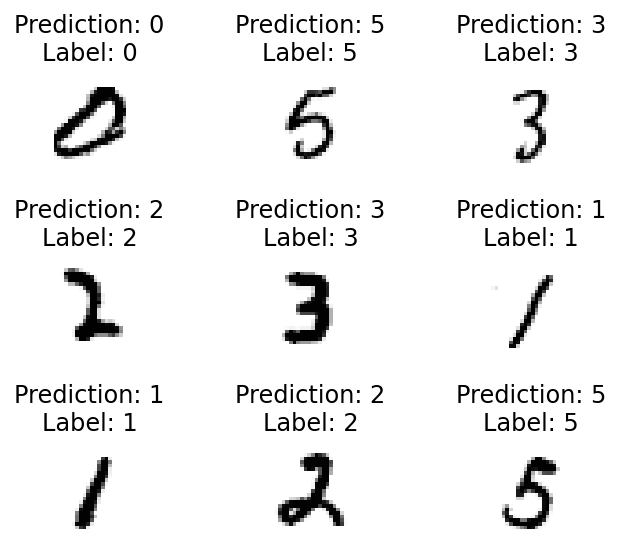

In [140]:
plot_predictions(nn_relu, X_test, y_test, 3, 3)

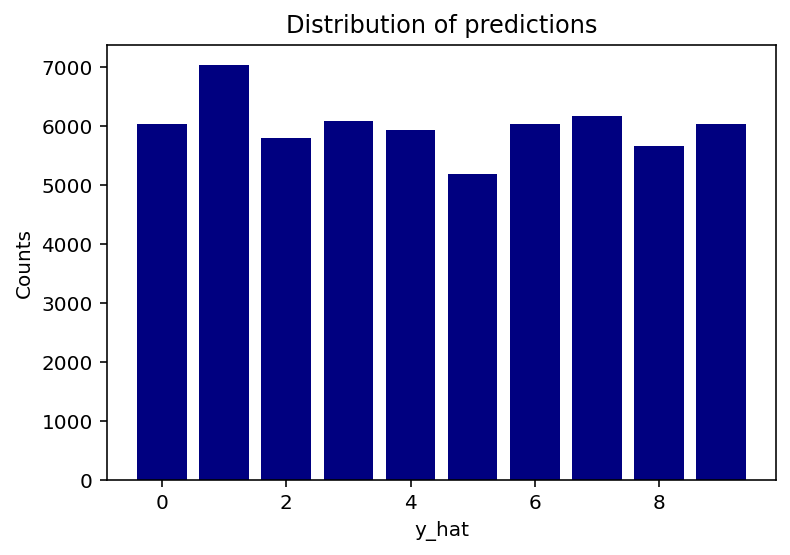

In [141]:
nn_relu.plot_counts()

## PyTorch simple implementation

In [61]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose

In [62]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    )

In [63]:
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    )

In [64]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


In [65]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [66]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [67]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [68]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [69]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.300775  [    0/60000]
loss: 2.301840  [ 6400/60000]
loss: 2.282770  [12800/60000]
loss: 2.284122  [19200/60000]
loss: 2.284169  [25600/60000]
loss: 2.283376  [32000/60000]
loss: 2.264910  [38400/60000]
loss: 2.276175  [44800/60000]
loss: 2.258247  [51200/60000]
loss: 2.246940  [57600/60000]
Test Error: 
 Accuracy: 43.2%, Avg loss: 2.255026 

Epoch 2
-------------------------------
loss: 2.252551  [    0/60000]
loss: 2.250427  [ 6400/60000]
loss: 2.243942  [12800/60000]
loss: 2.221015  [19200/60000]
loss: 2.234735  [25600/60000]
loss: 2.232835  [32000/60000]
loss: 2.203316  [38400/60000]
loss: 2.231014  [44800/60000]
loss: 2.195654  [51200/60000]
loss: 2.178700  [57600/60000]
Test Error: 
 Accuracy: 58.6%, Avg loss: 2.189478 

Epoch 3
-------------------------------
loss: 2.186056  [    0/60000]
loss: 2.177417  [ 6400/60000]
loss: 2.184645  [12800/60000]
loss: 2.127757  [19200/60000]
loss: 2.158648  [25600/60000]
loss: 2.153749  [32000/600

In [142]:
import cv2

In [143]:
def open_as_mnist(image_path):
    """
    Assume this is a color or grey scale image of a digit which has not so far been preprocessed

    Black and White
    Resize to 20 x 20 (digit in center ideally)
    Sharpen
    Add white border to make it 28 x 28
    Convert to white on black
    """
    # open as greyscale
    image = cv2.imread(image_path, 0)

    # crop to contour with largest area
    cropped = do_cropping(image)

    # resizing the image to 20 x 20
    resized20 = cv2.resize(cropped, (20, 20), interpolation=cv2.INTER_CUBIC)

    cv2.imwrite('1_resized.jpg', resized20)

    # gaussian filtering
    blurred = cv2.GaussianBlur(resized20, (3, 3), 0)

    # white digit on black background
    ret, thresh = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY_INV)

    padded = to20by20(thresh)


    resized28 = padded_image(padded, 28)

    # normalize the image values to fit in the range [0,1]
    norm_image = np.asarray(resized28, dtype=np.float32) / 255.

    # cv2.imshow('image', norm_image)
    # cv2.waitKey(0)

    # # Flatten the image to a 1-D vector and return
    flat = norm_image.reshape(1, 28 * 28)
    # return flat

    # normalize pixels to 0 and 1. 0 is pure white, 1 is pure black.
    tva = [(255 - x) * 1.0 / 255.0 for x in flat]
    return tva



def padded_image(image, tosize):
    """
    This method adds padding to the image and makes it to a tosize x tosize array,
    without losing the aspect ratio.
    Assumes desired image is square

    :param image: the input image as numpy array
    :param tosize: the final dimensions
    """

    # image dimensions
    image_height, image_width = image.shape


    # if not already square then pad to square
    if image_height != image_width:

        # Add padding
        # The aim is to make an image of different width and height to a sqaure image
        # For that first the biggest attribute among width and height are determined.
        max_index = np.argmax([image_height, image_width])


        # if height is the biggest one, then add padding to width until width becomes
        # equal to height
        if max_index == 0:
            #order of padding is: top, bottom, left, right
            left = int((image_height - image_width) / 2)
            right = image_height - image_width - left
            padded_img = cv2.copyMakeBorder(image, 0, 0,
                                            left,
                                            right,
                                            cv2.BORDER_CONSTANT)

        # else if width is the biggest one, then add padding to height until height becomes
        # equal to width
        else:
            top = int((image_width - image_height) / 2)
            bottom = image_width - image_height - top
            padded_img = cv2.copyMakeBorder(image, top, bottom, 0, 0,  cv2.BORDER_CONSTANT)
    else:
        padded_img = image


    # now that it's a square, add any additional padding required
    image_height, image_width = padded_img.shape
    padding = tosize - image_height

    # need to handle where padding is not divisiable by 2
    left = top = int(padding/2)
    right = bottom = padding - left
    resized = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT)


    return resized

In [39]:
nn_relu

## Using my own image

In [157]:
import cv2

In [165]:
img = cv2.imread("for_mnist2.jpeg", cv2.IMREAD_GRAYSCALE) # flag 0 imports to grayscale

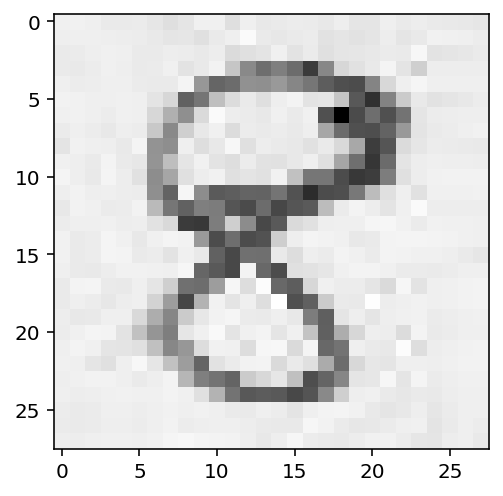

In [172]:
plt.imshow(img, cmap="Greys")

In [173]:
reshaped = np.asarray(img).reshape((X_test.shape[0], 1)) * 1.0

In [174]:
img

array([[ 45,  43,  46,  52,  53,  51,  57,  66,  58,  45,  45,  66,  46,
         55,  53,  50,  51,  55,  48,  59,  59,  47,  53,  49,  53,  54,
         55,  57],
       [ 48,  46,  46,  48,  49,  50,  54,  58,  57,  64,  52,  46,  27,
         52,  56,  53,  50,  62,  58,  62,  58,  49,  58,  54,  43,  44,
         47,  50],
       [ 53,  51,  48,  45,  47,  52,  52,  49,  50,  54,  49,  70,  64,
         60,  45,  61,  51,  65,  58,  57,  55,  51,  52,  33,  61,  59,
         56,  52],
       [ 53,  54,  50,  45,  48,  53,  51,  44,  61,  54,  42,  92, 138,
        160, 146, 162, 197, 140,  75,  63,  54,  38,  60,  82,  49,  49,
         49,  49],
       [ 47,  50,  49,  46,  47,  51,  53,  52,  38, 127, 167, 162, 132,
        133, 126, 141, 153, 174, 185, 187, 142,  74,  47,  36,  46,  46,
         46,  46],
       [ 42,  43,  46,  47,  44,  47,  60,  75, 170, 154,  99,  69,  52,
         66,  48,  40,  61,  59,  93, 178, 204, 143,  87,  54,  62,  59,
         55,  50],
       [ 4

In [175]:
reshaped

array([[ 45.],
       [ 43.],
       [ 46.],
       [ 52.],
       [ 53.],
       [ 51.],
       [ 57.],
       [ 66.],
       [ 58.],
       [ 45.],
       [ 45.],
       [ 66.],
       [ 46.],
       [ 55.],
       [ 53.],
       [ 50.],
       [ 51.],
       [ 55.],
       [ 48.],
       [ 59.],
       [ 59.],
       [ 47.],
       [ 53.],
       [ 49.],
       [ 53.],
       [ 54.],
       [ 55.],
       [ 57.],
       [ 48.],
       [ 46.],
       [ 46.],
       [ 48.],
       [ 49.],
       [ 50.],
       [ 54.],
       [ 58.],
       [ 57.],
       [ 64.],
       [ 52.],
       [ 46.],
       [ 27.],
       [ 52.],
       [ 56.],
       [ 53.],
       [ 50.],
       [ 62.],
       [ 58.],
       [ 62.],
       [ 58.],
       [ 49.],
       [ 58.],
       [ 54.],
       [ 43.],
       [ 44.],
       [ 47.],
       [ 50.],
       [ 53.],
       [ 51.],
       [ 48.],
       [ 45.],
       [ 47.],
       [ 52.],
       [ 52.],
       [ 49.],
       [ 50.],
       [ 54.],
       [ 4

In [176]:
nn_relu.predict(reshaped)

5

In [177]:
y_test[0].shape

(10000,)